Detected Number Plate Text: Za


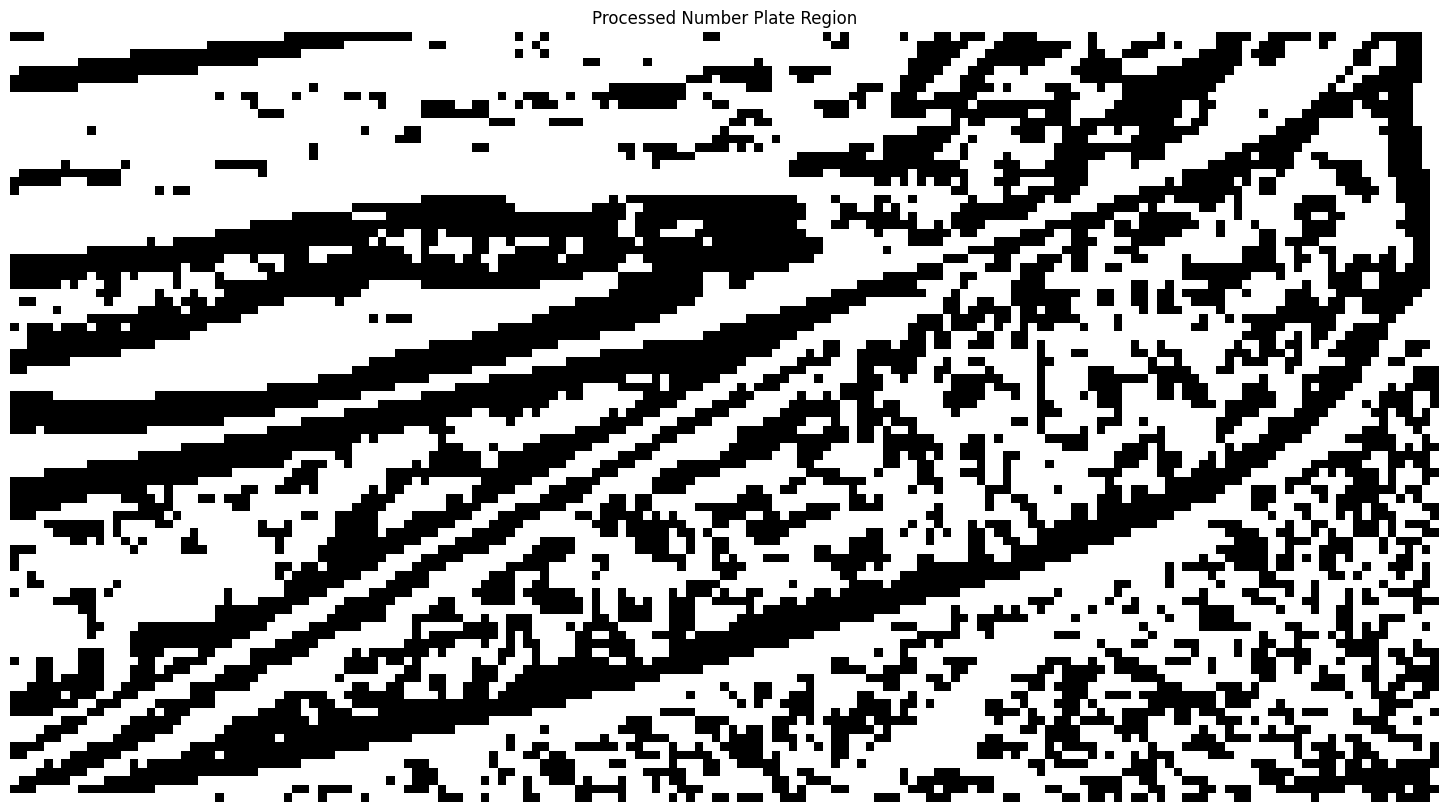

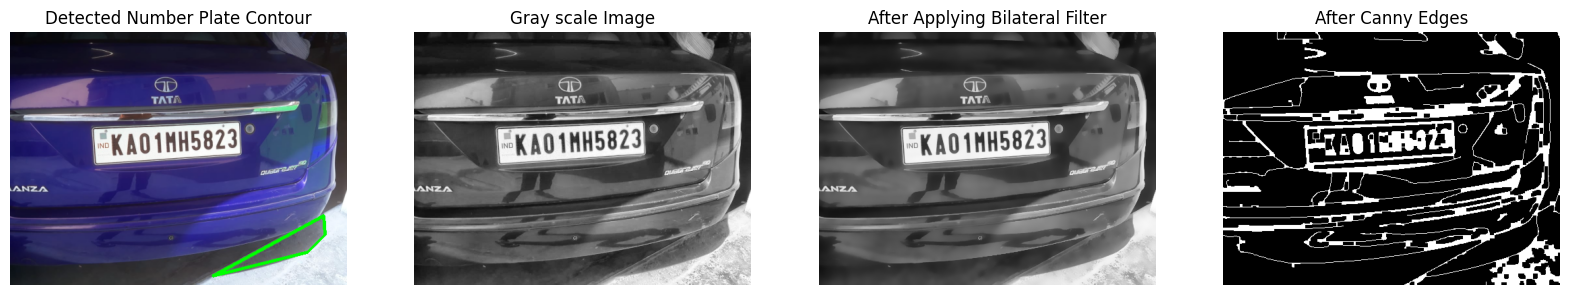

In [3]:
import cv2
import imutils
import matplotlib.pyplot as plt
import pytesseract
import numpy as np

# Function to display images using matplotlib
def display_images(images, titles):
    plt.figure(figsize=(20, 10))
    for i, (image, title) in enumerate(zip(images, titles)):
        plt.subplot(1, len(images), i + 1)
        plt.title(title)
        plt.imshow(image if len(image.shape) == 3 else cv2.cvtColor(image, cv2.COLOR_BGR2RGB), cmap='gray')
        plt.axis('off')
    plt.show()

# Load the image
input_image = '16734556_F_2024-04-04_1712224618.jpeg'  # Replace with your image file
image = cv2.imread(input_image)

# Resize the image
new_width = 500
image = imutils.resize(image, width=new_width)

# Convert to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply CLAHE for contrast improvement
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
gray = clahe.apply(gray)

# Apply bilateral filter
filtered_img = cv2.bilateralFilter(gray, 11, 17, 17)

# Edge detection using Canny
edged = cv2.Canny(filtered_img, 30, 200)

# Morphological operations to close gaps between edges
kernel = np.ones((5, 5), np.uint8)
edged = cv2.dilate(edged, kernel, iterations=1)
edged = cv2.erode(edged, kernel, iterations=1)

# Find contours
cnts = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts = sorted(cnts, key=cv2.contourArea, reverse=True)[:10]

# Initialize variables
NumberPlateCnt = None
number_plate_number = None

# Loop over contours to find the number plate contour
for c in cnts:
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.018 * peri, True)
    if len(approx) == 4:
        NumberPlateCnt = approx
        break

# If number plate contour is found
if NumberPlateCnt is not None:
    # Draw the contour on the original image
    cv2.drawContours(image, [NumberPlateCnt], -1, (0, 255, 0), 3)

    # Crop and preprocess the number plate region
    x, y, w, h = cv2.boundingRect(NumberPlateCnt)
    roi = gray[y:y + h, x:x + w]

    # Use adaptive thresholding to handle different lighting conditions
    thresh = cv2.adaptiveThreshold(roi, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)

    # Perform OCR on the cropped number plate region
    text = pytesseract.image_to_string(thresh, config='--psm 8')
    print("Detected Number Plate Text:", text.strip())

    # Check for the presence of "IND" in the text
    if "IND" in text:
        ind_present = "Yes"
    else:
        ind_present = "No"
    
    #print("Is 'IND' present on the number plate?", ind_present)

    # Display the processed number plate region
    display_images([thresh], ["Processed Number Plate Region"])
else:
    print("No contour with 4 sides found.")

# Display the original image with the contour
display_images([image, gray, filtered_img, edged], ["Detected Number Plate Contour", "Gray scale Image", "After Applying Bilateral Filter", "After Canny Edges"])
